# Gradient Boosting: a practical guide

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

## Model selection guide

### Warm-started models and early-stopping

### Stochastic Gradient Boosting

### Randomized paramater search

This feature is being implemented directly in scikit-learn as part of [PR #5689](https://github.com/scikit-learn/scikit-learn/pull/5689) but can be implemented manually easily in the mean time:

## Probability calibration for classification confidence

Example application: realtime bidding: bid ~= CTR * Expected revenue per click.
Sometimes it's better not to issue not to bid if we know that the likelihood of a user to click on a given ad is below a threshold.

## 

## Limitations

###  Regression with homogeneous feature interactions

### Multiclass classification

Possibly better models for multiclass classification with a large number of classes:

- Linear models: multi-nomial logistic regression: might require extensive feature engineering to model non-linear interactions in original space. Nystrom method migth be useful.
- Random Forests
- Neural Networks (MLP)

### High-dimensional feature spaces and noisy features

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import median_absolute_error


calhousing = fetch_california_housing()

X, y = calhousing.data, calhousing.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=0)

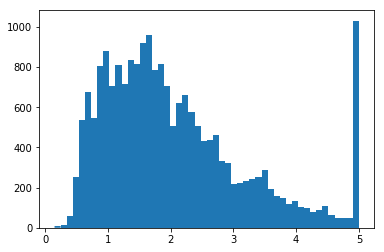

In [21]:
plt.hist(y, bins=50);

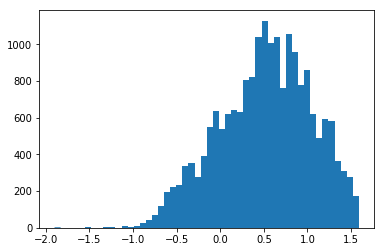

In [23]:
plt.hist(np.log(y[y < 4.9]), bins=50);

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, make_union

lm = make_pipeline(
    StandardScaler(),
    make_union(
        FunctionTransformer(lambda x: x),
        PolynomialFeatures(degree=4)
    ),
    LinearRegression())
lm.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.2f, test error: %0.2f" %
      (median_absolute_error(y_train, np.exp(lm.predict(X_train))),
       median_absolute_error(y_test[y_test < 4.9], np.exp(lm.predict(X_test[y_test < 4.9])))))

train error: 0.25, test error: 0.24


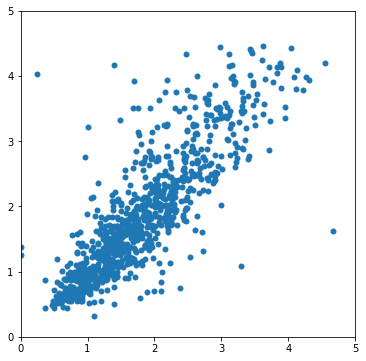

In [64]:
plt.figure(figsize=(6, 6))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.scatter(np.exp(lm.predict(X_test[y_test < 4.5])), y_test[y_test < 4.5]);

In [ ]:
from sklearn.kernel_approximation import Nystroem

nystroem = make_pipeline(
    make_union(
        FunctionTransformer(lambda x: x),
        PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    ),
    MinMaxScaler(),
    LinearRegression())
lm.fit(X_train[y_train < 4.9], np.log(y_train[y_train < 4.9]))

print("train error: %0.2f, test error: %0.2f" %
      (median_absolute_error(y_train, np.exp(lm.predict(X_train))),
       median_absolute_error(y_test[y_test < 4.9], np.exp(lm.predict(X_test[y_test < 4.9])))))

In [26]:
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=12, n_estimators=50)
gbr.fit(X_train, y_train)
print("train error: %0.2f, test error: %0.2f" %
      (median_absolute_error(y_train, gbr.predict(X_train)),
       median_absolute_error(y_test, gbr.predict(X_test))))

train error: 0.06, test error: 0.18


In [27]:
from pickle import dumps
len(dumps(gbr)) / 1e6

11.670192

In [28]:
%time _ = gbr.predict(X_test[:100])

CPU times: user 3.06 ms, sys: 0 ns, total: 3.06 ms
Wall time: 2.51 ms


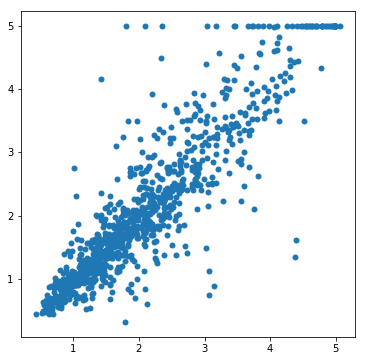

In [30]:
plt.figure(figsize=(6, 6))
plt.scatter(gbr.predict(X_test), y_test);

In [161]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(learning_rate=0.1, max_depth=12, n_estimators=50).fit(X_train, y_train)
print("train error: %0.2f, test error: %0.2f" %
      (median_absolute_error(y_train, xgbr.predict(X_train)),
       median_absolute_error(y_test, xgbr.predict(X_test))))

train error: 0.07, test error: 0.18


In [189]:
%time _ = xgbr.predict(X_test[:100])

CPU times: user 118 ms, sys: 237 µs, total: 118 ms
Wall time: 11.8 ms


In [214]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(min_samples_leaf=2, max_features=8, n_estimators=500, n_jobs=-1)
rfr.fit(X_train, y_train)
print("train error: %0.2f, test error: %0.2f" %
      (median_absolute_error(y_train, rfr.predict(X_train)),
       median_absolute_error(y_test, rfr.predict(X_test))))

train error: 0.08, test error: 0.19


In [212]:
np.sqrt(X_train.shape[1])

2.8284271247461903

In [201]:
from pickle import dumps
len(dumps(rfr)) / 1e6

338.143879

In [192]:
%time _ = rfr.predict(X_test[:100])

CPU times: user 253 ms, sys: 16.5 ms, total: 269 ms
Wall time: 209 ms


In [202]:
def add_noise_features(X, n_noise_features):
    X_noise = np.random.randn(X.shape[0], n_noise_features)
    return np.hstack([X, X_noise])

In [223]:
for n_noise_features in [0, 100]:
    X_train_noise = add_noise_features(X_train, n_noise_features)
    X_test_noise = add_noise_features(X_test, n_noise_features)
    xgbr = XGBRegressor(learning_rate=0.1, max_depth=12, n_estimators=50)
    xgbr.fit(X_train_noise, y_train)
    print("n_noise_features=%d, train error: %0.2f, test error: %0.2f" %
        (n_noise_features,
         median_absolute_error(y_train, xgbr.predict(X_train_noise)),
         median_absolute_error(y_test, xgbr.predict(X_test_noise))))

n_noise_features=0, train error: 0.07, test error: 0.18
n_noise_features=100, train error: 0.05, test error: 0.21


In [222]:
for n_noise_features in [0, 100]:
    X_train_noise = add_noise_features(X_train, n_noise_features)
    X_test_noise = add_noise_features(X_test, n_noise_features)
    gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=12, n_estimators=50)
    gbr.fit(X_train_noise, y_train)
    print("n_noise_features=%d, train error: %0.2f, test error: %0.2f" %
        (n_noise_features,
         median_absolute_error(y_train, gbr.predict(X_train_noise)),
         median_absolute_error(y_test, gbr.predict(X_test_noise))))

n_noise_features=0, train error: 0.06, test error: 0.19
n_noise_features=100, train error: 0.04, test error: 0.22


In [221]:
for n_noise_features in [0, 100]:
    X_train_noise = add_noise_features(X_train, n_noise_features)
    X_test_noise = add_noise_features(X_test, n_noise_features)
    rfr = RandomForestRegressor(n_jobs=-1, min_samples_leaf=3, max_features=min(30, X_train_noise.shape[1]), n_estimators=500)
    rfr.fit(X_train_noise, y_train)
    print("n_noise_features=%d, train error: %0.2f, test error: %0.2f" %
        (n_noise_features,
         median_absolute_error(y_train, rfr.predict(X_train_noise)),
         median_absolute_error(y_test, rfr.predict(X_test_noise))))

n_noise_features=0, train error: 0.10, test error: 0.19
n_noise_features=100, train error: 0.12, test error: 0.27


## XGBoost

XGBoost provides a more efficient implementation and notably supports multi-threading via a scikit-learn compatible interface. 

It also supports out-of-core and distributed model fitting although via a different API.

Most of the practical recommendations of this guide still apply when using XGBoost instead of scikit-learn models.